In [1]:
import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense,  Dropout, Input, LSTM, Embedding,SpatialDropout1D, BatchNormalization, Flatten, LayerNormalization
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import tensorflow_text as text

import pandas_tfrecords as pdtfr

import matplotlib.pyplot as plt
import re

import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.corpus import wordnet as wn
from nltk import word_tokenize,pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from collections import defaultdict        
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from pathlib import Path


from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import pickle
from sklearn.metrics import confusion_matrix

import keras_tuner as kt
import seaborn as sns
import tensorflow_datasets as tfds


tf.random.set_seed(0)
np.random.seed(0)
stop_words_list = stopwords.words('english') 

#tf.config.run_functions_eagerly(True)
#import tensorflow_data_validation as tfdv
#tf.debugging.set_log_device_placement(True)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


from transformers import  RobertaTokenizer, TFRobertaModel



2024-07-30 11:41:38.378137: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-30 11:41:38.771273: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-30 11:41:39.597651: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/n/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /home/n/nltk_data...
[nltk_dat

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17375611254865270778
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2032140288
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2181478278394597285
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


2024-07-30 11:41:42.010608: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-30 11:41:42.019454: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-30 11:41:42.178653: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Num GPUs Available:  1


2024-07-30 11:41:42.636888: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-30 11:41:42.638563: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-30 11:41:42.640063: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# Read dataset


In [2]:
dataset, info = tfds.load('imdb_reviews', with_info=True, 
                          as_supervised=True)

train_dataset, test_dataset = dataset['train'], dataset['test']
train_dataset

2024-07-30 11:41:43.194780: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-30 11:41:43.196664: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-30 11:41:43.198277: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

<_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [3]:
for i, o in train_dataset.take(1):
    print(i.shape, o.shape)
    print(i, o)

() ()
tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string) tf.Tensor(0, shape=(), dtype=int64)


2024-07-30 11:41:43.358817: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-07-30 11:41:43.359692: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [4]:
def convert_tfdataframe_to_pddataframe(tf_df):
    data_list = []
    for i, (features, label) in enumerate(tf_df):
        
        if i % 5000 == 0 : print(f"{i}/{len(tf_df)}")
        
        data_list.append((features.numpy().decode('utf-8'), label.numpy()))

    # Create a Pandas DataFrame
    return pd.DataFrame(data_list, columns = [ "review", "sentiment"])

# Create a Pandas DataFrame
train_dataset = convert_tfdataframe_to_pddataframe(train_dataset)
train_dataset

0/25000
5000/25000
10000/25000
15000/25000
20000/25000


2024-07-30 11:41:44.973594: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


review  sentiment
0      This was an absolutely terrible movie. Don't b...          0
1      I have been known to fall asleep during films,...          0
2      Mann photographs the Alberta Rocky Mountains i...          0
3      This is the kind of film for a snowy Sunday af...          1
4      As others have mentioned, all the women that g...          1
...                                                  ...        ...
24995  I have a severe problem with this show, severa...          0
24996  The year is 1964. Ernesto "Che" Guevara, havin...          1
24997  Okay. So I just got back. Before I start my re...          0
24998  When I saw this trailer on TV I was surprised....          0
24999  First of all, Riget is wonderful. Good comedy ...          1

[25000 rows x 2 columns]

In [5]:
# Create a Pandas DataFrame
test_dataset = convert_tfdataframe_to_pddataframe(test_dataset)
test_dataset

0/25000
5000/25000
10000/25000
15000/25000
20000/25000


2024-07-30 11:41:46.913291: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


review  sentiment
0      There are films that make careers. For George ...          1
1      A blackly comic tale of a down-trodden priest,...          1
2      Scary Movie 1-4, Epic Movie, Date Movie, Meet ...          0
3      Poor Shirley MacLaine tries hard to lend some ...          0
4      As a former Erasmus student I enjoyed this fil...          1
...                                                  ...        ...
24995  Feeling Minnesota is not really a road movie, ...          0
24996  This is, without doubt, one of my favourite ho...          1
24997  Most predicable movie I've ever seen...extreme...          0
24998  It's exactly what I expected from it. Relaxing...          1
24999  They just don't make cartoons like they used t...          1

[25000 rows x 2 columns]

# Check statistics

In [6]:
train_dataset.dtypes

review       object
sentiment     int64
dtype: object

In [7]:
# # Instantiate a StatsOptions class and define the feature_allowlist property
# stats_options = tfdv.StatsOptions(
#     feature_allowlist=train_dataset.columns.tolist(),
#     enable_semantic_domain_stats= True # Because we are processing text
#     )
# stats_options

In [8]:
# train_stats = tfdv.generate_statistics_from_dataframe(train_dataset, stats_options) 

# # get the number of features used to compute statistics
# print(f"Number of features used: {len(train_stats.datasets[0].features)}")

# # check the number of examples used
# print(f"Number of examples used: {train_stats.datasets[0].num_examples}")

# # check the column names of the first and last feature
# print(f"First feature: {train_stats.datasets[0].features[0].path.step[0]}")
# print(f"Last feature: {train_stats.datasets[0].features[-1].path.step[0]}")
# tfdv.visualize_statistics(train_stats)


# Set Parameters

In [9]:
batchsize=512

ETL_STOPWORDS= False
PREPARE_TRAINIG_DATA= False
TRAIN_MODE= True

TUNNING = True
INFERENCE_MODE = True

threshold = 1
classN=1
min_freq = 4



In [10]:

DATA_CHECKPOINTS_DIR = './checkpoints'
tfrecord_filename = "train_tmp.tfrecord"
train_tmp_record_path = f'{DATA_CHECKPOINTS_DIR}/{tfrecord_filename}'

!mkdir -p {DATA_CHECKPOINTS_DIR}



# Set Functions to perform data cleaning and feature engineering

In [11]:
def check_word_frequency(train_df):
    
    print("Dataset lentgh : ",len(train_df))

    tokenizer = Tokenizer(filters='!"#$%&()*+,-/:;=?@[\\]^_´`«»{|}~\t\n\'',oov_token='<oov>')# sequence_size = 500 ~= mean+ std sentence size
    tokenizer.fit_on_texts(train_df.review.values.tolist())

    word_frequency = {}
    for i, (word, count) in enumerate(tokenizer.word_counts.items()):
        word_frequency[word]=count
            
    return word_frequency


def update_stop_words(word_frequency, freq,max_freq,stop_word):
 
    it = 0
    for word, count in word_frequency.items():
        if count < freq:
            if it < 10:
                print(word)
                it +=1
            stop_word.append(word)
        elif count >max_freq :
            stop_word.append(word)
            
    return list(set(stop_word))


word_frequency= check_word_frequency(train_dataset)
max_freq = np.max(list(word_frequency.values())) +1 
# Update stop words list with the less frequent 
updated_stop_word = update_stop_words(word_frequency, min_freq, max_freq, stop_words_list.copy())

Dataset lentgh :  25000
ironside.
revolutions.
sette
accord
gunfighters
>canadian
paddle
symptoms.
barometers
microscopically


In [12]:
len(updated_stop_word)/len(word_frequency)

0.6626352641629535

In [13]:

def limit_words_tf(review, sentiment):
    # Split the string into tokens
    tokens = tf.strings.split(review)

    # Limit the number of tokens to max_words
    limited_tokens = tokens[:sequence_size]
    
    # Join the tokens back into a string
    limited_review = tf.strings.reduce_join(limited_tokens, separator=' ')
        
    return limited_review, sentiment



def save_record(dataset, record_path):

    with tf.io.TFRecordWriter(record_path) as writer:
        for index, row in dataset.iterrows():
            input_ids, attention_mask, sentiment = row["input_ids"], row["attention_mask"], row["sentiment"]
            # Serialize example
            feature = {
                'input_ids': tf.train.Feature(int64_list=tf.train.Int64List(value=input_ids)),  # List feature
                'attention_mask': tf.train.Feature(float_list=tf.train.FloatList(value=attention_mask)), # List feature
                'sentiment': tf.train.Feature(int64_list=tf.train.Int64List(value=[sentiment])) # Single value feature
            }
            example_proto = tf.train.Example(features=tf.train.Features(feature=feature)).SerializeToString()
            
            writer.write(example_proto)

def clean_reviews(review, sentiment):
    
    lowercase = tf.strings.lower(review)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    
    tokens = tf.strings.split(stripped_html)
    # Filter out words to remove
    words_to_remove_tensor = tf.constant(updated_stop_word)
    mask = tf.logical_not(tf.reduce_any(tf.equal(tokens, words_to_remove_tensor[:, tf.newaxis]), axis=0))
    
    # Filter out words to remove
    filtered_tokens = tf.boolean_mask(tokens, mask)
    
    # Join the remaining tokens back into a string
    processed_data = tf.strings.reduce_join(filtered_tokens, separator=' ')
    
    sentence_size = len(tf.strings.split(processed_data))
    return (processed_data, sentiment , sentence_size)
    
def process_stop_words(td_dataset):

    # Convert to tf.dataset
    td_dataset = tf.data.Dataset.from_tensor_slices((td_dataset['review'], td_dataset['sentiment']))

    for i, o in td_dataset.take(1):
        print(i.shape, o.shape)
        print("Pre processed ds : ",i, o )
   
    
    td_dataset = td_dataset.map(clean_reviews, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    for i, o, l in td_dataset.take(3):
        print("Post processed ds : ",l, o, i )
        
    data_list_element = []
    total_len = len(td_dataset)

    print(f"Starting Extraction in batches {total_len} ...")
    for i, (features, label, size) in enumerate(td_dataset.take(total_len)):
        if i % 1000 == 0 : print(f"{i}/{total_len}")
        
        data_list_element.append((features.numpy(), label.numpy(), size.numpy()))
    
    print("Creating dataframe....")
    return pd.DataFrame(data_list_element, columns = [ "review", "sentiment", "size"])

if ETL_STOPWORDS:
    train_ds = process_stop_words(train_dataset)
    train_ds.to_pickle(f"{DATA_CHECKPOINTS_DIR}/train_ds.pkl")  
    
    display(train_ds)
    test_ds  = process_stop_words(test_dataset)
    test_ds.to_pickle(f"{DATA_CHECKPOINTS_DIR}/test_ds.pkl") 
    display(test_ds) 
else:
    train_ds = pd.read_pickle(f"{DATA_CHECKPOINTS_DIR}/train_ds.pkl")  
    test_ds = pd.read_pickle(f"{DATA_CHECKPOINTS_DIR}/test_ds.pkl") 



In [14]:
train_ds.review = train_ds.review.apply(lambda x : x.decode("utf-8"))
test_ds.review = test_ds.review.apply(lambda x : x.decode("utf-8"))

In [15]:
if ETL_STOPWORDS:
   
    
    #print("Converting to dataframe ..")
    #train_ds = train_ds.cache()#.prefetch(tf.data.experimental.AUTOTUNE)
    #test_ds = test_ds.cache()#.prefetch(tf.data.experimental.AUTOTUNE)
    #train_ds =  tfds.as_dataframe(train_ds, info) 
    #test_ds =  tfds.as_dataframe(test_ds, info) 
    # train_ds =  convert_tfdataframe_to_pddataframe(train_ds)#tfds.as_dataframe(train_ds, info) 
    # test_ds =  convert_tfdataframe_to_pddataframe(test_ds)#tfds.as_dataframe(train_ds, info) 

    with open(f'{DATA_CHECKPOINTS_DIR}/word_frequency.pkl', 'wb') as f:
        pickle.dump(word_frequency, f)

    with open(f'{DATA_CHECKPOINTS_DIR}/updated_stop_word.pkl', 'wb') as f:
        pickle.dump(updated_stop_word, f)

else:
    
    with open(f'{DATA_CHECKPOINTS_DIR}/word_frequency.pkl', 'rb') as f:
        word_frequency = pickle.load(f)
        
    with open(f'{DATA_CHECKPOINTS_DIR}/updated_stop_word.pkl', 'rb') as f:
        updated_stop_word = pickle.load(f)

        


# Check sentence size
 

In [16]:
train_ds["size"].describe()

count    25000.000000
mean       122.220720
std         92.135317
min          4.000000
25%         65.000000
50%         90.000000
75%        149.000000
max       1395.000000
Name: size, dtype: float64

In [17]:
train_ds[train_ds["size"] > 800].review.values[0]

'match 1: tag team table match bubba ray spike dudley vs eddie guerrero chris benoit bubba ray spike dudley started things tag team table match eddie guerrero chris according rules match, opponents go tables order get win. benoit guerrero heated early taking turns hammering first spike bubba ray. german benoit bubba took wind dudley brother. spike tried help brother, referee restrained benoit guerrero corner. benoit stomping away bubba, guerrero set table outside. spike dashed ring top rope onto guerrero outside! recovering taking care spike, guerrero slipped table ring helped wolverine set up. tandem set double superplex middle rope would put bubba table, spike knocked table right brother came crashing down! guerrero benoit propped another table corner tried irish whip spike it, bubba dashed blocked brother. bubba caught fire lifted opponents back body drops! bubba slammed guerrero spike stomped wolverine top rope. bubba held benoit bay spike soar wassup! headbutt! shortly after, beno

count    25000.000000
mean       120.193120
std         90.088172
min          3.000000
25%         65.000000
50%         90.000000
75%        146.000000
max       1183.000000
Name: size, dtype: float64

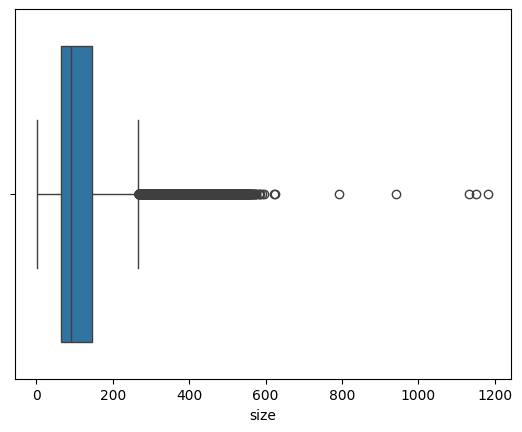

In [18]:
sns.boxplot(x=test_ds['size'])
test_ds["size"].describe()

Finding the outliers to fix the sentence size . Every sample with size considered as outlier will be trimmed

In [19]:

Q1_train = train_ds["size"].quantile(0.25)
Q3_train = train_ds["size"].quantile(0.75)
IQR_train = Q3_train - Q1_train
print("Train Q1_train : ",Q1_train)
print("Train Q3_train : ",Q3_train)
print("Train IQR : ",IQR_train)
print("Final training dataset size : ",(Q1_train - 1.5 * IQR_train),(Q3_train + 1.5 * IQR_train), len(train_ds[ train_ds["size"] <= (Q3_train + 1.5 * IQR_train)]))
print("Training data to be trimed : ",len(train_ds[ train_ds["size"] > (Q3_train + 1.5 * IQR_train)]))


Train Q1_train :  65.0
Train Q3_train :  149.0
Train IQR :  84.0
Final training dataset size :  -61.0 275.0 23199
Training data to be trimed :  1801


In [20]:
Q1_test = test_ds["size"].quantile(0.25)
Q3_test = test_ds["size"].quantile(0.75)
IQR_test = Q3_test - Q1_test

print("Test IQR : ",IQR_test)
print("Final testing dataset size : ",(Q1_test - 1.5 * IQR_test),(Q3_test + 1.5 * IQR_test), len(test_ds[ test_ds["size"] <= (Q3_test + 1.5 * IQR_test)]))
print("Testing data to be trimed : ",len(test_ds[ test_ds["size"] > (Q3_test + 1.5 * IQR_test)]))


Test IQR :  81.0
Final testing dataset size :  -56.5 267.5 23137
Testing data to be trimed :  1863


Apply the sentence cut

In [21]:
IQR_total = np.maximum((Q3_train + 1.5 * IQR_train),(Q3_test + 1.5 * IQR_test))
sequence_size = int(IQR_total)
sequence_size

275

In [22]:
test_ds = test_ds[test_ds['size'] > 0] 
train_ds = train_ds[train_ds['size'] > 0] 



In [23]:

def limit_words(review):
    # Split the string into tokens
    tokens = review.split()

    # Limit the number of tokens to max_words
    limited_tokens = tokens[:sequence_size]
    
    # Join the tokens back into a string
    limited_review = ' '.join(limited_tokens)
        
    return limited_review

print("Cleaning training dataset - sentences size processing ")
train_ds["cleaned_review"] = train_ds.review.apply(lambda x : limit_words(x)) 
train_ds["cleaned_size"] = train_ds.cleaned_review.apply(lambda x : len(x.split())) 

print("Cleaning testing dataset - sentences size processing ")
test_ds["cleaned_review"] = test_ds.review.apply(lambda x : limit_words(x)) 
test_ds["cleaned_size"] = test_ds.cleaned_review.apply(lambda x : len(x.split())) 

num_labels = len(train_ds.sentiment.unique())  # number of labels for your classification task

display(train_ds)
display(test_ds)

Cleaning training dataset - sentences size processing 
Cleaning testing dataset - sentences size processing 


review  sentiment  size  \
0      absolutely terrible movie. lured christopher w...          0    65   
1      known fall asleep films, usually due combinati...          0    52   
2      mann photographs alberta rocky mountains super...          0    75   
3      kind film snowy sunday afternoon rest world go...          1    45   
4      others mentioned, women go nude film mostly ab...          1    40   
...                                                  ...        ...   ...   
24995  severe problem show, several actually. simple ...          0   266   
24996  year ernesto "che" guevara, cuban citizen last...          1    95   
24997  okay. got back. start review, let tell one thi...          0   394   
24998  saw trailer tv surprised. may 2008 six flags n...          0    78   
24999  first all, riget wonderful. good comedy myster...          1   162   

                                          cleaned_review  cleaned_size  
0      absolutely terrible movie. lured christopher w...            65  
1      known fall asleep films, usually due combinati...            52  
2      mann photographs alberta rocky mountains super...            75  
3      kind film snowy sunday afternoon rest world go...            45  
4      others mentioned, women go nude film mostly ab...            40  
...                                                  ...           ...  
24995  severe problem show, several actually. simple ...           266  
24996  year ernesto "che" guevara, cuban citizen last...            95  
24997  okay. got back. start review, let tell one thi...           275  
24998  saw trailer tv surprised. may 2008 six flags n...            78  
24999  first all, riget wonderful. good comedy myster...           162  

[25000 rows x 5 columns]

review  sentiment  size  \
0      films make careers. george romero, night livin...          1    89   
1      comic tale down-trodden priest, nazarin showca...          1   159   
2      scary movie 1-4, epic movie, date movie, meet ...          0   301   
3      poor shirley maclaine tries hard lend gravitas...          0   146   
4      former student enjoyed film much. realistic fu...          1    38   
...                                                  ...        ...   ...   
24995  feeling minnesota really road movie, that's st...          0    99   
24996  is, without doubt, one favourite horror films ...          1   158   
24997  predicable movie i've ever seen...extremely bo...          0    91   
24998  exactly expected it. relaxing, humorous entert...          1    42   
24999  make cartoons like used to. one wit, great cha...          1    32   

                                          cleaned_review  cleaned_size  
0      films make careers. george romero, night livin...            89  
1      comic tale down-trodden priest, nazarin showca...           159  
2      scary movie 1-4, epic movie, date movie, meet ...           275  
3      poor shirley maclaine tries hard lend gravitas...           146  
4      former student enjoyed film much. realistic fu...            38  
...                                                  ...           ...  
24995  feeling minnesota really road movie, that's st...            99  
24996  is, without doubt, one favourite horror films ...           158  
24997  predicable movie i've ever seen...extremely bo...            91  
24998  exactly expected it. relaxing, humorous entert...            42  
24999  make cartoons like used to. one wit, great cha...            32  

[25000 rows x 5 columns]

Before thinking on trimming, we must check if any important sentiment information will not be deleted.

# Tokenize and prepare embeddings

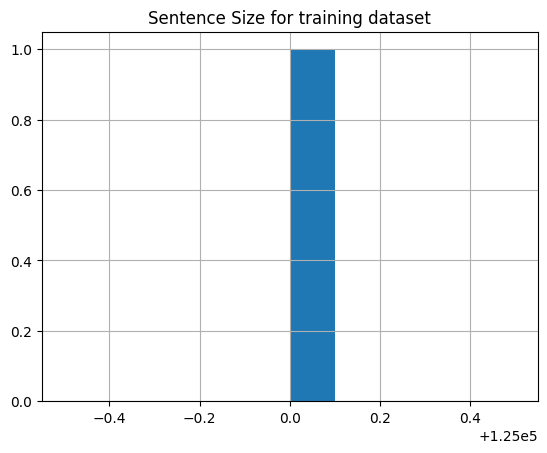

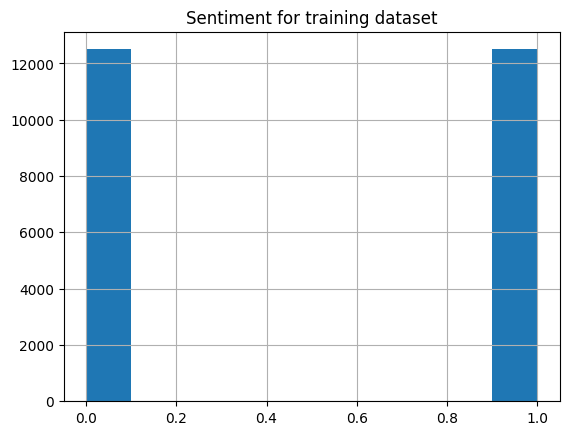

count         1.0
mean     125000.0
std           NaN
min      125000.0
25%      125000.0
50%      125000.0
75%      125000.0
max      125000.0
dtype: float64


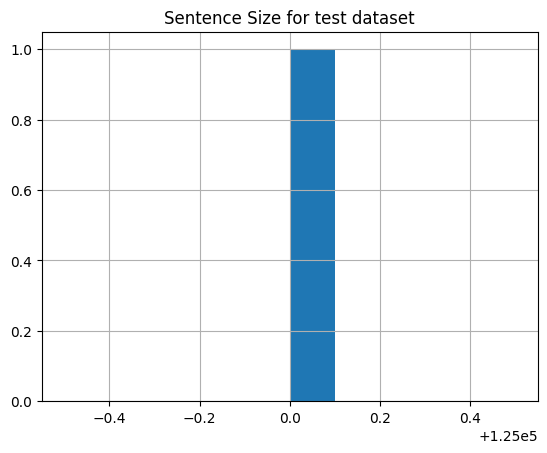

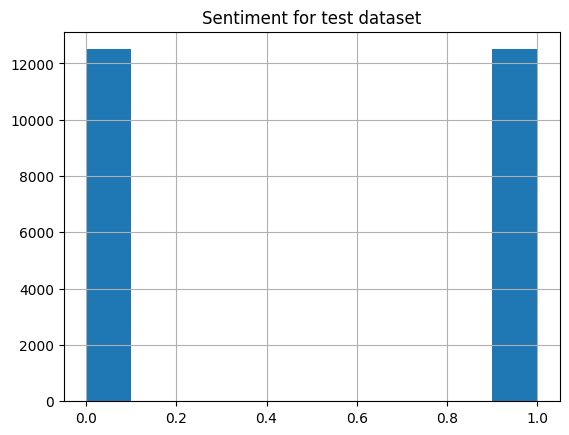

count         1.0
mean     125000.0
std           NaN
min      125000.0
25%      125000.0
50%      125000.0
75%      125000.0
max      125000.0
dtype: float64


In [24]:
plt.figure()
pd.Series(train_ds.size).hist(bins=10)
plt.title("Sentence Size for training dataset")

plt.figure()
pd.Series(train_ds.sentiment).hist()
plt.title("Sentiment for training dataset")

plt.show()
print(pd.Series(train_ds.size).describe())

plt.figure()
pd.Series(test_ds.size).hist()
plt.title("Sentence Size for test dataset")

plt.figure()
pd.Series(test_ds.sentiment).hist()
plt.title("Sentiment for test dataset")

plt.show()
print(pd.Series(test_ds.size).describe())

In [25]:
num_labels = len(train_ds.sentiment.unique())  # number of labels for your classification task
model_name = 'roberta-base'  # or specify the path to a custom model
tokenizer = RobertaTokenizer.from_pretrained(model_name)
encoder = TFRobertaModel.from_pretrained(model_name)
encoder.trainable = False

def encode_text(row):
    cleaned_review = row["cleaned_review"]

    out = tokenizer.encode_plus(
        cleaned_review,
        add_special_tokens=True,
        max_length=sequence_size,  # specify the maximum length of your input
        pad_to_max_length=True,
        return_attention_mask=True
    )
    return out["input_ids"], out["attention_mask"]

train_ds[["input_ids","attention_mask"]] = train_ds.apply(encode_text, axis=1, result_type='expand')
test_ds[["input_ids","attention_mask"]] = test_ds.apply(encode_text, axis=1, result_type='expand')

display(train_ds)
display(test_ds)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

review  sentiment  size  \
0      absolutely terrible movie. lured christopher w...          0    65   
1      known fall asleep films, usually due combinati...          0    52   
2      mann photographs alberta rocky mountains super...          0    75   
3      kind film snowy sunday afternoon rest world go...          1    45   
4      others mentioned, women go nude film mostly ab...          1    40   
...                                                  ...        ...   ...   
24995  severe problem show, several actually. simple ...          0   266   
24996  year ernesto "che" guevara, cuban citizen last...          1    95   
24997  okay. got back. start review, let tell one thi...          0   394   
24998  saw trailer tv surprised. may 2008 six flags n...          0    78   
24999  first all, riget wonderful. good comedy myster...          1   162   

                                          cleaned_review  cleaned_size  \
0      absolutely terrible movie. lured christopher w...            65   
1      known fall asleep films, usually due combinati...            52   
2      mann photographs alberta rocky mountains super...            75   
3      kind film snowy sunday afternoon rest world go...            45   
4      others mentioned, women go nude film mostly ab...            40   
...                                                  ...           ...   
24995  severe problem show, several actually. simple ...           266   
24996  year ernesto "che" guevara, cuban citizen last...            95   
24997  okay. got back. start review, let tell one thi...           275   
24998  saw trailer tv surprised. may 2008 six flags n...            78   
24999  first all, riget wonderful. good comedy myster...           162   

                                               input_ids  \
0      [0, 24002, 6587, 1569, 4, 25653, 29224, 35885,...   
1      [0, 6421, 1136, 15028, 3541, 6, 2333, 528, 406...   
2      [0, 4621, 9065, 1076, 6747, 102, 18443, 9787, ...   
3      [0, 11584, 822, 28932, 28087, 857, 1390, 1079,...   
4      [0, 7443, 29, 2801, 6, 390, 213, 16109, 822, 2...   
...                                                  ...   
24995  [0, 26251, 936, 311, 6, 484, 888, 4, 2007, 889...   
24996  [0, 180, 1437, 3281, 990, 139, 22, 2871, 113, ...   
24997  [0, 1638, 857, 4, 300, 124, 4, 386, 1551, 6, 9...   
24998  [0, 35349, 5611, 30016, 3911, 4, 189, 2266, 41...   
24999  [0, 9502, 70, 6, 10727, 594, 4613, 4, 205, 531...   

                                          attention_mask  
0      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
1      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
2      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
3      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
4      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
...                                                  ...  
24995  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
24996  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
24997  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
24998  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
24999  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  

[25000 rows x 7 columns]

review  sentiment  size  \
0      films make careers. george romero, night livin...          1    89   
1      comic tale down-trodden priest, nazarin showca...          1   159   
2      scary movie 1-4, epic movie, date movie, meet ...          0   301   
3      poor shirley maclaine tries hard lend gravitas...          0   146   
4      former student enjoyed film much. realistic fu...          1    38   
...                                                  ...        ...   ...   
24995  feeling minnesota really road movie, that's st...          0    99   
24996  is, without doubt, one favourite horror films ...          1   158   
24997  predicable movie i've ever seen...extremely bo...          0    91   
24998  exactly expected it. relaxing, humorous entert...          1    42   
24999  make cartoons like used to. one wit, great cha...          1    32   

                                          cleaned_review  cleaned_size  \
0      films make careers. george romero, night livin...            89   
1      comic tale down-trodden priest, nazarin showca...           159   
2      scary movie 1-4, epic movie, date movie, meet ...           275   
3      poor shirley maclaine tries hard lend gravitas...           146   
4      former student enjoyed film much. realistic fu...            38   
...                                                  ...           ...   
24995  feeling minnesota really road movie, that's st...            99   
24996  is, without doubt, one favourite horror films ...           158   
24997  predicable movie i've ever seen...extremely bo...            91   
24998  exactly expected it. relaxing, humorous entert...            42   
24999  make cartoons like used to. one wit, great cha...            32   

                                               input_ids  \
0      [0, 18419, 4339, 146, 8478, 4, 5473, 26875, 14...   
1      [0, 175, 636, 10390, 159, 12, 19937, 39893, 13...   
2      [0, 3866, 1766, 1569, 112, 12, 306, 6, 9066, 1...   
3      [0, 29557, 1481, 853, 607, 13418, 462, 5193, 5...   
4      [0, 22098, 1294, 3776, 822, 203, 4, 10556, 626...   
...                                                  ...   
24995  [0, 7068, 10244, 5251, 46295, 269, 921, 1569, ...   
24996  [0, 354, 6, 396, 2980, 6, 65, 5548, 8444, 3541...   
24997  [0, 37466, 26092, 1569, 939, 348, 655, 450, 73...   
24998  [0, 3463, 45548, 421, 24, 4, 19448, 6, 31214, ...   
24999  [0, 19746, 32162, 101, 341, 7, 4, 65, 22094, 6...   

                                          attention_mask  
0      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
1      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
2      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
3      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
4      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
...                                                  ...  
24995  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
24996  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
24997  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
24998  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
24999  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  

[25000 rows x 7 columns]

In [26]:
train_ds = train_ds[["input_ids","attention_mask","sentiment"]]
test_ds = test_ds[["input_ids","attention_mask","sentiment"]]
train_ds.sentiment = train_ds.sentiment.astype("int8")
test_ds.sentiment = test_ds.sentiment.astype("int8")

display(train_ds)
display(test_ds)

input_ids  \
0      [0, 24002, 6587, 1569, 4, 25653, 29224, 35885,...   
1      [0, 6421, 1136, 15028, 3541, 6, 2333, 528, 406...   
2      [0, 4621, 9065, 1076, 6747, 102, 18443, 9787, ...   
3      [0, 11584, 822, 28932, 28087, 857, 1390, 1079,...   
4      [0, 7443, 29, 2801, 6, 390, 213, 16109, 822, 2...   
...                                                  ...   
24995  [0, 26251, 936, 311, 6, 484, 888, 4, 2007, 889...   
24996  [0, 180, 1437, 3281, 990, 139, 22, 2871, 113, ...   
24997  [0, 1638, 857, 4, 300, 124, 4, 386, 1551, 6, 9...   
24998  [0, 35349, 5611, 30016, 3911, 4, 189, 2266, 41...   
24999  [0, 9502, 70, 6, 10727, 594, 4613, 4, 205, 531...   

                                          attention_mask  sentiment  
0      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...          0  
1      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...          0  
2      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...          0  
3      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...          1  
4      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...          1  
...                                                  ...        ...  
24995  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...          0  
24996  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...          1  
24997  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...          0  
24998  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...          0  
24999  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...          1  

[25000 rows x 3 columns]

input_ids  \
0      [0, 18419, 4339, 146, 8478, 4, 5473, 26875, 14...   
1      [0, 175, 636, 10390, 159, 12, 19937, 39893, 13...   
2      [0, 3866, 1766, 1569, 112, 12, 306, 6, 9066, 1...   
3      [0, 29557, 1481, 853, 607, 13418, 462, 5193, 5...   
4      [0, 22098, 1294, 3776, 822, 203, 4, 10556, 626...   
...                                                  ...   
24995  [0, 7068, 10244, 5251, 46295, 269, 921, 1569, ...   
24996  [0, 354, 6, 396, 2980, 6, 65, 5548, 8444, 3541...   
24997  [0, 37466, 26092, 1569, 939, 348, 655, 450, 73...   
24998  [0, 3463, 45548, 421, 24, 4, 19448, 6, 31214, ...   
24999  [0, 19746, 32162, 101, 341, 7, 4, 65, 22094, 6...   

                                          attention_mask  sentiment  
0      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...          1  
1      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...          1  
2      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...          0  
3      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...          0  
4      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...          1  
...                                                  ...        ...  
24995  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...          0  
24996  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...          1  
24997  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...          0  
24998  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...          1  
24999  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...          1  

[25000 rows x 3 columns]

In [27]:
# Directory for caching
DATA_CACHING_DIR = './cache'
cache_training_path = f'{DATA_CACHING_DIR}/training_chache'
cache_testing_path = f'{DATA_CACHING_DIR}/testing_cache'

data_training_path = f'{DATA_CACHING_DIR}/training_ds.tfrecord'
data_testing_path = f'{DATA_CACHING_DIR}/testing_ds.tfrecord'
!mkdir -p {DATA_CACHING_DIR}


def read_record_parse_function(proto):

    feature_description = {
        'input_ids': tf.io.VarLenFeature(tf.int64),# List feature
        'attention_mask': tf.io.VarLenFeature(tf.float32),# List feature
        'sentiment': tf.io.FixedLenFeature([], tf.int64)# Single value feature
    }

    # Parse the input `tf.train.Example` proto using the feature description dictionary
    parsed_features = tf.io.parse_single_example(proto, feature_description)

    features = {
        'input_ids': tf.sparse.to_dense(parsed_features['input_ids']),
        'attention_mask': tf.sparse.to_dense(parsed_features['attention_mask'])
    }
    sentiment = parsed_features['sentiment']
    return features, sentiment

def read_tf_record(record_path):
    # Create a dataset of records

    raw_dataset = tf.data.TFRecordDataset(record_path)
    parsed_dataset = raw_dataset.map(read_record_parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    return parsed_dataset
    
            



Saving the data to the disk to clean memory after

In [28]:
# if PREPARE_TRAINIG_DATA:
#     save_record(train_ds, data_training_path)
#     save_record(test_ds, data_testing_path)

# del train_ds
# del test_ds


In [29]:
# train_processed_ds = read_tf_record(data_training_path).batch(batchsize).shuffle(buffer_size=10000)#.prefetch(tf.data.AUTOTUNE)
# test_processed_ds = read_tf_record(data_testing_path).batch(batchsize).shuffle(buffer_size=10000)#.prefetch(tf.data.AUTOTUNE)

In [30]:
train_tfds = tf.data.Dataset.from_tensor_slices(
        (
            (train_ds.input_ids.tolist(), train_ds.attention_mask.tolist()), 
            train_ds.sentiment.tolist()
        )
    ).batch(batchsize).shuffle(buffer_size=len(train_ds)).prefetch(tf.data.AUTOTUNE)

test_tfds = tf.data.Dataset.from_tensor_slices(
        (
            (test_ds.input_ids.tolist(), test_ds.attention_mask.tolist()), 
            test_ds.sentiment.tolist()
        )
    ).batch(batchsize).shuffle(buffer_size=len(test_ds)).prefetch(tf.data.AUTOTUNE)

for i, o in train_tfds.take(1):
    i_id, i_mask = i[0], i[1]
    print(i_id)
    print(i_mask)
    print(o)

tf.Tensor(
[[    0 27905  3212 ...     1     1     1]
 [    0 22111  1153 ...     1     1     1]
 [    0 10273  5971 ...     1     1     1]
 ...
 [    0 29669  7618 ...   546   124     2]
 [    0 17701 38089 ...     1     1     1]
 [    0  8155   102 ...     1     1     1]], shape=(512, 275), dtype=int32)
tf.Tensor(
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]], shape=(512, 275), dtype=int32)
tf.Tensor(
[1 0 1 1 1 0 0 1 1 0 1 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1
 0 1 0 1 1 1 1 1 1 0 1 1 0 1 1 1 0 0 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 1 1 1 1
 0 1 1 1 1 1 0 0 0 1 0 0 1 0 0 0 1 1 0 1 1 1 0 1 0 0 0 1 1 1 1 1 0 1 0 0 0
 1 0 0 1 1 0 1 1 1 0 0 1 0 0 1 1 1 0 0 1 1 1 0 0 1 0 0 1 0 1 1 1 1 1 1 1 0
 1 0 0 1 1 1 0 0 1 0 1 1 1 0 1 0 1 0 0 0 1 0 0 1 0 1 1 1 0 1 1 1 0 1 0 1 1
 1 0 1 0 1 1 0 1 1 0 0 1 1 0 1 1 1 0 1 0 1 0 1 1 0 1 1 1 0 0 1 0 1 0 1 1 0
 1 0 0 1 1 0 1 0 1 0 1 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 0 0 

2024-07-30 11:42:28.910675: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Deep learning  model training process

### Run training process 


In [31]:

class SentimentModel(tf.keras.Model):
    def __init__(self,  n_classes =1,  dense_units_list = [32], dropout_units_list= [0.1], n_dense_layer = 1,  n_lstm_layers = 1, lstm_units = [128],model_name = 'roberta-base'):
        super(SentimentModel, self).__init__()
        
        self.num_layers = n_dense_layer
        self.dense_layers = [Dense(dense_units_list[i], activation='relu') for i in range(self.num_layers)]

        self.dropout_layers =[]
        if self.num_layers > 1:
            self.dropout_layers = [Dropout(dropout_units_list[i]) for i in range(self.num_layers-1)]
            self.batch_norms = [BatchNormalization() for i in range(self.num_layers-1)]
        
        self.encoder = TFRobertaModel.from_pretrained(model_name)
        self.encoder.trainable = False
        self.flatten = tf.keras.layers.Flatten()
        self.output_dense = Dense(n_classes, activation='sigmoid')

        self.lstm_units = lstm_units
        self.n_lstm_layers = n_lstm_layers


        self.lstm_layers = []
        for i in range(self.n_lstm_layers):
            if i == self.n_lstm_layers-1:
                self.lstm_layers.append(LSTM(lstm_units[i], return_sequences=False, return_state = False) )
            else:
                self.lstm_layers.append(LSTM(lstm_units[i], return_sequences=True, return_state = False) )
    
    def call(self, inputs):
        # Get mean and standard deviation from the policy network
        input_ids, attention_mask = inputs[0], inputs[1]
        x = self.encoder((input_ids, attention_mask))[0]
        for i in range(self.n_lstm_layers):
            x  = self.lstm_layers[i](x)

        x = self.flatten(x)
        for i in range(self.num_layers):
            x = self.dense_layers[i](x)
            
            if i < (self.num_layers - 1) and  self.num_layers > 1:
                x = self.batch_norms[i](x)
                x = self.dropout_layers[i](x)

        classes  = self.output_dense(x)

        return classes

# test_sentiment_model =SentimentModel(n_classes = 1)
# test_sentiment_model.compile(optimizer=Adam(learning_rate=0.0001), loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics =[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.AUC()])
# for i, o in train_tfds.take(1):
#     test_sentiment_model(i)
# test_sentiment_model.summary()


In [32]:
# test_sentiment_model.fit(train_tfds,  epochs=5, batch_size=batchsize, validation_data = test_tfds, verbose =1)

In [33]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=f"logs/tunning/")

def get_model_tunning(hp):

    pr = tf.keras.metrics.AUC(curve="PR")
    p = tf.keras.metrics.Precision()
    r = tf.keras.metrics.Recall()

    n_dense_layers = hp.Int('max_n_dense', 1, 2)
    dense_units_list =  [hp.Int('dense_units_'+str(i), 32, 128) for i in range(n_dense_layers)]

    n_lstm_layers = 1#hp.Int('max_n_lstm', 1, 2)
    lstm_units = []
    if n_lstm_layers > 0:
        lstm_units =  [hp.Int('lstm_units_'+str(i), 32, 128) for i in range(n_lstm_layers)]

    dropout_units_list = []
    if n_dense_layers > 1:
        dropout_units_list =  [hp.Float('dropout_units_'+str(i), 0.1, 0.5, step = 0.1) for i in range(n_dense_layers-1)]
    
    hp_learning_rate = hp.Float('learning_rate', 0.000001, 0.001)

    model =SentimentModel(
        n_classes = 1, 
        dense_units_list = dense_units_list, 
        dropout_units_list= dropout_units_list, 
        n_dense_layer = n_dense_layers,
        lstm_units = lstm_units,
        n_lstm_layers = n_lstm_layers
        )
    
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics =[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.AUC(), pr, p, r])
    for i, o in train_tfds.take(1):
        model(i)

    return model


tuner = kt.BayesianOptimization(
        get_model_tunning,
        objective= kt.Objective('val_auc', direction="max"), #kt.Objective('val_auc', direction="max"),# #val_binary_accuracy
        max_trials = 20,
        directory=r"Hyperparam_tunning",
        project_name='keras_tunning',
    )

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=35)#val_auc
if TUNNING:
    tuner.search(train_tfds,  epochs=100, batch_size=batchsize, validation_data = test_tfds, verbose =1, callbacks=[stop_early, tensorboard_callback]) 

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

ResourceExhaustedError: Exception encountered when calling layer 'embeddings' (type TFRobertaEmbeddings).

{{function_node __wrapped__ResourceGather_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[512,275,768] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:ResourceGather] name: 

Call arguments received by layer 'embeddings' (type TFRobertaEmbeddings):
  • input_ids=tf.Tensor(shape=(512, 275), dtype=int32)
  • position_ids=None
  • token_type_ids=tf.Tensor(shape=(512, 275), dtype=int32)
  • inputs_embeds=None
  • past_key_values_length=0
  • training=False

In [ ]:
aaaaaaaaaaaaaaa

In [ ]:
model_dynamic = get_model_dynamic(best_hps)

if FIT_MODEL:
    
    history = model_dynamic.fit(x[0], y, 
              batch_size=batchsize, 
              epochs=300,
              shuffle=True,
              validation_data = (x_dev[0],y_dev),
              callbacks=[PlotLossesCallback() ,stop_early]
             )
    
    model_dynamic.save(f'{DATA_CHECKPOINTS_DIR}_dynamic/model_dynamic')

    with open(f'{DATA_CHECKPOINTS_DIR}_dynamic/history.pickle', 'wb') as handle:
        pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)


else:
    model_dynamic = tf.keras.models.load_model(f'{DATA_CHECKPOINTS_DIR}_dynamic/model_dynamic')

    with open(f'{DATA_CHECKPOINTS_DIR}_dynamic/history.pickle', 'rb') as handle:
        history = pickle.load(handle)
        plt.figure()
        plt.plot(history['binary_accuracy'])
        plt.plot(history['val_binary_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')

        plt.figure()
        plt.plot(history['loss'])
        plt.plot(history['val_loss'])
        plt.title('Model training loss')
        plt.ylabel('Loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')

        plt.show()

In [ ]:
yhat =model_dynamic.predict(x_test[0][0:100])
yhat[yhat >=0.5] = 1
yhat[yhat < 0.5] = 0 
yhat

y_test = y_test.reshape((len(y_test),1))
y_test
print("x 1º line : "+str(x))
print("y : ",y) 
print("y_test : ",y_test) 

In [ ]:

yhat =model_dynamic.predict(x_test)
yhat[yhat >=0.5] = 1
yhat[yhat < 0.5] = 0 
y_test = y_test.reshape((len(y_test),1))

pr = tf.keras.metrics.AUC(curve="PR")
print()

p = tf.keras.metrics.Precision()
p.update_state(y_test,yhat)

r = tf.keras.metrics.Recall()
r.update_state(y_test,yhat)

base_pr = pr(y_test, yhat).numpy()
base_p = p.result().numpy()
base_r = r.result().numpy()
print("AUC",base_pr," | Precision : ",base_p, " | Recall : ",base_r)


In [ ]:
confusion_matrix(list(y_test),list(yhat))

In [ ]:

base_tn, base_fp, base_fn, base_tp = confusion_matrix(list(y_test),list(yhat)).ravel()
base_tn, base_fp, base_fn, base_tp



In [ ]:
def print_predictions(X, pred):
    for i in range(len(X)):
        xx = [tokenizer.index_word.get(ind) for ind in X[i] if tokenizer.index_word.get(ind) is not None]
        print(' '.join(xx), "Prediction :", int(pred[i])," - Real :",y_test[i][0],"\n")
        
        if i==10:
            break

print_predictions(x_test[0], yhat)